In [1]:
import  os
import  pandas as pd
from    tqdm import tqdm
import  numpy as np
from    multiprocessing import get_context as context
from    matplotlib import pyplot as plt
%matplotlib inline

# Read the files

# Parameters


header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']
PROCESSES   = os.cpu_count()-1
Pool        = context("fork").Pool

# Find the files
foldername  = f'/scratch/tengiz/horizontal100M'
os.system(f'rm -rf /scratch/tengiz/horizontal100M.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def parallel(function):
    def inner(input_array):
        # Parallelize excecution them
        with Pool(PROCESSES) as pool:
            output = list(tqdm(pool.imap(function, input_array),total=len(input_array)))
        return output 
    return inner

# Function to load a single file
def loadfile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

Found 19 data files in /scratch/tengiz/horizontal100M


In [2]:
def processFile(filename):
    
    veto = loadfile(filename)
    veto = veto[veto.Volume.str.contains('veto')]
    veto = veto.groupby(['Filename','EventID', 'Volume'])['EnergyDeposited'].sum().reset_index()
    veto = veto[veto.EnergyDeposited > 10**(-9)]


    # loading the rest of the dataframe
    data = loadfile(filename)
    data = data[~(data.Volume.str.contains('veto'))]
    data = data.groupby(['Filename','EventID', 'Volume'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data[data['EnergyDeposited'] > 10**(-9)]

    return veto,data


processFiles        = parallel(processFile)
processed           = processFiles(filenames)

100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


In [3]:
vetos = [i[0] for i in processed]
datas = [i[1] for i in processed]

In [4]:
veto = pd.concat(vetos)
data = pd.concat(datas)

In [5]:
veto = veto.rename(columns={'EnergyDeposited':'vetoEnergy'})
veto = veto.drop(columns='Volume')

In [6]:
crystal1 = data[data['Volume'] == 'crystal1_PV']
crystal2 = data[data['Volume'] == 'crystal2_PV']
crystal3 = data[data['Volume'] == 'crystal3_PV']
crystal4 = data[data['Volume'] == 'crystal4_PV']
crystal1_2 = data[data['Volume'].isin(['crystal1_PV','crystal2_PV'])]
crystal1_2_3_4 = data[data['Volume'].isin(['crystal1_PV','crystal2_PV','crystal3_PV','crystal4_PV'])]

In [7]:
# Veto + crystal1 coincidence

def coincidence(data1: pd.DataFrame, data2: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes in dataframes that have only one volume.
    It merges them based on their EventID and sums their energies
    """
    combined = pd.DataFrame.merge(data1, data2, how = 'inner', on=['Filename','EventID'])
    if 'EnergyDeposited_x' in combined.columns:
        combined['EnergyDeposited'] = combined['EnergyDeposited_x'] + combined['EnergyDeposited_y']
    columns_to_drop = ['EnergyDeposited_x','EnergyDeposited_y', 'Volume_x', 'Volume_y','Volume']
    for column in columns_to_drop:
        if column in combined.columns:
            combined = combined.drop(columns=column)
    return combined

def union(data1: pd.DataFrame, data2: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes in two dataframes that have only one volume
    It concats them based on their EventID as a union
    """

    combined = pd.concat([data1,data2])
    return combined

In [8]:
veto_and_1 = coincidence(veto,crystal1)


In [9]:
veto_and_1

,Filename,EventID,vetoEnergy,EnergyDeposited
0,TES-run0-rank8_nt_hits.csv,399,1.593318,4.335682
1,TES-run0-rank8_nt_hits.csv,3523,2.132889,13.106900
2,TES-run0-rank8_nt_hits.csv,10573,0.896514,22.634428
3,TES-run0-rank8_nt_hits.csv,13175,0.033150,6.458969
4,TES-run0-rank8_nt_hits.csv,14072,1.998085,15.040005
...,...,...,...,...
58441,TES-run0-rank4_nt_hits.csv,5249931,0.956616,18.539232
58442,TES-run0-rank4_nt_hits.csv,5254182,4.419966,1.365230
58443,TES-run0-rank4_nt_hits.csv,5258218,2.259154,19.533163
58444,TES-run0-rank4_nt_hits.csv,5258374,1.261485,1.027990


In [10]:
veto_and_1or2 = coincidence(veto,crystal1_2)
veto_and_1or2

,Filename,EventID,vetoEnergy,EnergyDeposited
0,TES-run0-rank8_nt_hits.csv,399,1.593318,4.335682
1,TES-run0-rank8_nt_hits.csv,399,1.593318,19.365145
2,TES-run0-rank8_nt_hits.csv,422,1.009450,0.984708
3,TES-run0-rank8_nt_hits.csv,2481,1.831872,16.305700
4,TES-run0-rank8_nt_hits.csv,3523,2.132889,13.106900
...,...,...,...,...
116452,TES-run0-rank4_nt_hits.csv,5258218,2.259154,0.881502
116453,TES-run0-rank4_nt_hits.csv,5258374,1.261485,1.027990
116454,TES-run0-rank4_nt_hits.csv,5259515,1.121540,11.506700
116455,TES-run0-rank4_nt_hits.csv,5261112,1.981504,0.047104


In [11]:
veto_and_1or2or3or4 = coincidence(veto,crystal1_2_3_4)
veto_and_1or2or3or4

,Filename,EventID,vetoEnergy,EnergyDeposited
0,TES-run0-rank8_nt_hits.csv,68,0.855991,3.651216
1,TES-run0-rank8_nt_hits.csv,399,1.593318,4.335682
2,TES-run0-rank8_nt_hits.csv,399,1.593318,19.365145
3,TES-run0-rank8_nt_hits.csv,399,1.593318,0.328699
4,TES-run0-rank8_nt_hits.csv,422,1.009450,0.984708
...,...,...,...,...
235441,TES-run0-rank4_nt_hits.csv,5260302,2.152235,17.020455
235442,TES-run0-rank4_nt_hits.csv,5261112,1.981504,0.047104
235443,TES-run0-rank4_nt_hits.csv,5262373,0.960517,14.168593
235444,TES-run0-rank4_nt_hits.csv,5263102,0.968185,0.225366


In [12]:
def message(value, text):
    percent = round(value*100,2)
    print(f'{text} = {percent}%')

In [13]:
# Veto and crystal1 
value = len(veto_and_1)/len(veto)
message(value, 'Veto and crystal1 / veto')

Veto and crystal1 / veto = 23.47%


In [14]:
# (Not veto) and crystal1
value = ((len(crystal1) - len(veto_and_1))/(len(crystal1)))
message(value, 'Crystal1 and (not Veto) / (Crystal1)')

Crystal1 and (not Veto) / (Crystal1) = 23.48%


In [15]:
# Veto and (crystal1 or crystal2)
value = len(veto_and_1or2)/len(veto)
message(value, 'Veto and (Crystal1 or Crystal2) / veto')

Veto and (Crystal1 or Crystal2) / veto = 46.76%


In [16]:
# (Not veto) and (crystal1 or crytal2)

value = (len(crystal1_2)-len(veto_and_1or2))/(len(crystal1_2))
percent = round(value*100,1)
print(f'(Crystal1 or Crystal2) and (not Veto) / (Crystal1 or Crystal2) = {percent}%')

(Crystal1 or Crystal2) and (not Veto) / (Crystal1 or Crystal2) = 23.4%


In [17]:
# Veto and union(1,2,3,4) / veto

value = (len(veto_and_1or2or3or4)/len(veto))

message(value, 'Union(1,2,3,4) and veto / veto')

Union(1,2,3,4) and veto / veto = 94.54%


In [18]:
# (Not veto) and union(1,2,3,4)

value = (len(crystal1_2_3_4)-len(veto_and_1or2or3or4))/(len(crystal1_2_3_4))
percent = round(value*100,1)
print(f'Union(1,2,3,4) and (not Veto) / Union(1,2,3,4) = {percent}%')

Union(1,2,3,4) and (not Veto) / Union(1,2,3,4) = 24.1%


# Check for particle content in veto

In [2]:
def processFile(filename):
    
    veto = loadfile(filename)
    veto = veto[veto.Volume.str.contains('veto')]
    veto = veto[veto.EnergyDeposited > 10**(-9)]

    return veto


processFiles        = parallel(processFile)
processed           = processFiles(filenames)

100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


In [3]:
veto = pd.concat(processed)

In [4]:
veto

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,TES-run0-rank8_nt_hits.csv,68,1,e-,0.000391,7.15580,37.9979,-19.9523,2.049880e+00,veto_PV,6.196790e+04,world_volume_PV,-1
1,TES-run0-rank8_nt_hits.csv,68,1,e-,0.000067,7.15548,37.9970,-19.9525,2.049890e+00,veto_PV,6.196790e+04,world_volume_PV,-1
3,TES-run0-rank8_nt_hits.csv,68,1,e-,0.000077,7.15525,37.9963,-19.9527,2.049890e+00,veto_PV,6.196790e+04,world_volume_PV,-1
4,TES-run0-rank8_nt_hits.csv,68,1,e-,0.000470,7.15493,37.9953,-19.9530,2.049890e+00,veto_PV,6.196790e+04,world_volume_PV,-1
5,TES-run0-rank8_nt_hits.csv,68,1,e-,0.000305,7.15350,37.9910,-19.9543,2.049910e+00,veto_PV,6.196790e+04,world_volume_PV,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627794,TES-run0-rank4_nt_hits.csv,5262373,1,mu+,0.960235,43.46640,33.0000,16.1944,2.074160e+00,veto_PV,7.059230e+05,world_volume_PV,-1
1627888,TES-run0-rank4_nt_hits.csv,5262373,2,gamma,0.000017,43.12290,34.7832,15.5117,1.361780e-05,veto_PV,2.820200e-01,NaN,-1
1627889,TES-run0-rank4_nt_hits.csv,5262373,17,e-,0.000052,43.12290,34.7832,15.5117,6.679470e-08,veto_PV,2.654300e-01,veto_PV,-1
1627890,TES-run0-rank4_nt_hits.csv,5262373,17,e-,0.000214,43.12290,34.7832,15.5117,3.300100e-07,veto_PV,2.654300e-01,veto_PV,-1


In [5]:
original_particle = veto[veto['Origin Volume'] == 'world_volume_PV']
original_particle = original_particle.groupby(['Filename','EventID'])['Particle'].unique().reset_index()

In [6]:
veto = veto.groupby(['Filename','EventID'])['EnergyDeposited'].sum().reset_index()

In [7]:
original_particle

,Filename,EventID,Particle
0,TES-run0-rank0_nt_hits.csv,138,[mu+]
1,TES-run0-rank0_nt_hits.csv,366,[mu-]
2,TES-run0-rank0_nt_hits.csv,746,[gamma]
3,TES-run0-rank0_nt_hits.csv,1008,[mu+]
4,TES-run0-rank0_nt_hits.csv,1942,[mu+]
...,...,...,...
228921,TES-run0-rank9_nt_hits.csv,5262018,[mu-]
228922,TES-run0-rank9_nt_hits.csv,5262160,[e-]
228923,TES-run0-rank9_nt_hits.csv,5262330,[mu-]
228924,TES-run0-rank9_nt_hits.csv,5262358,[mu+]


In [8]:
veto

,Filename,EventID,EnergyDeposited
0,TES-run0-rank0_nt_hits.csv,138,0.536786
1,TES-run0-rank0_nt_hits.csv,366,1.943186
2,TES-run0-rank0_nt_hits.csv,746,1.320221
3,TES-run0-rank0_nt_hits.csv,844,6.759126
4,TES-run0-rank0_nt_hits.csv,1008,1.046480
...,...,...,...
249051,TES-run0-rank9_nt_hits.csv,5262018,2.174550
249052,TES-run0-rank9_nt_hits.csv,5262160,0.914302
249053,TES-run0-rank9_nt_hits.csv,5262330,0.967705
249054,TES-run0-rank9_nt_hits.csv,5262358,11.611741


In [9]:
data = pd.merge(veto, original_particle, on=['Filename','EventID'], how='inner')
data

,Filename,EventID,EnergyDeposited,Particle
0,TES-run0-rank0_nt_hits.csv,138,0.536786,[mu+]
1,TES-run0-rank0_nt_hits.csv,366,1.943186,[mu-]
2,TES-run0-rank0_nt_hits.csv,746,1.320221,[gamma]
3,TES-run0-rank0_nt_hits.csv,1008,1.046480,[mu+]
4,TES-run0-rank0_nt_hits.csv,1942,2.703123,[mu+]
...,...,...,...,...
228921,TES-run0-rank9_nt_hits.csv,5262018,2.174550,[mu-]
228922,TES-run0-rank9_nt_hits.csv,5262160,0.914302,[e-]
228923,TES-run0-rank9_nt_hits.csv,5262330,0.967705,[mu-]
228924,TES-run0-rank9_nt_hits.csv,5262358,11.611741,[mu+]


In [10]:
data = data[data.Particle.apply(lambda x: len(x) == 1)].copy()
data.Particle = data.Particle.apply(lambda x: x[0])
data

,Filename,EventID,EnergyDeposited,Particle
0,TES-run0-rank0_nt_hits.csv,138,0.536786,mu+
1,TES-run0-rank0_nt_hits.csv,366,1.943186,mu-
2,TES-run0-rank0_nt_hits.csv,746,1.320221,gamma
3,TES-run0-rank0_nt_hits.csv,1008,1.046480,mu+
4,TES-run0-rank0_nt_hits.csv,1942,2.703123,mu+
...,...,...,...,...
228921,TES-run0-rank9_nt_hits.csv,5262018,2.174550,mu-
228922,TES-run0-rank9_nt_hits.csv,5262160,0.914302,e-
228923,TES-run0-rank9_nt_hits.csv,5262330,0.967705,mu-
228924,TES-run0-rank9_nt_hits.csv,5262358,11.611741,mu+


<BarContainer object of 9 artists>

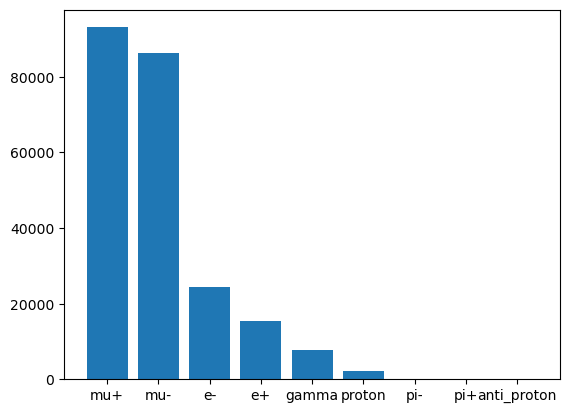

In [11]:
counts = data.Particle.value_counts()

plt.bar(counts.index, counts.values, align='center')

In [12]:
counts

Particle
mu+            93141
mu-            86190
e-             24490
e+             15327
gamma           7602
proton          2104
pi-               33
pi+               19
anti_proton        6
Name: count, dtype: int64

In [13]:
counts.to_csv('particle_frequency.csv', index = False)

In [14]:
energy = data.groupby(['Particle'])['EnergyDeposited'].mean().reset_index()
energy

,Particle,EnergyDeposited
0,anti_proton,3.447523
1,e+,2.303796
2,e-,2.176537
3,gamma,0.912374
4,mu+,2.433215
5,mu-,2.410982
6,pi+,3.515440
7,pi-,2.123782
8,proton,5.455402


Text(0.5, 1.0, 'Average energy deposition by cosmic rays in veto')

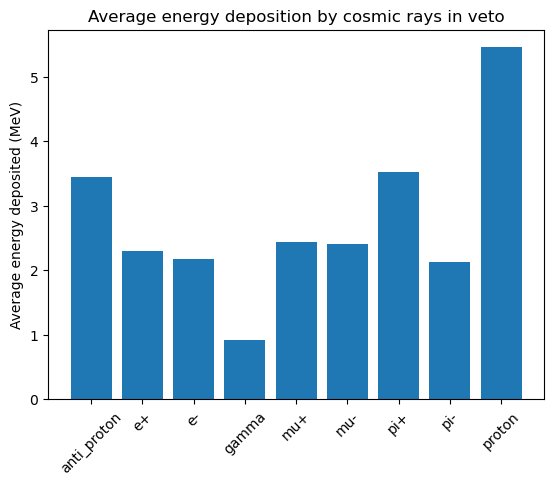

In [17]:
plt.bar(energy.Particle, energy.EnergyDeposited, align='center')
plt.ylabel('Average energy deposited (MeV)')
plt.xticks(rotation=45)
plt.title('Average energy deposition by cosmic rays in veto')

In [18]:
energy.to_csv('veto_energy.csv', index = False)